# California Housing Regression
### Kate Stadelman
### Data Mining, Winter 2022

In [1]:
# data and regression libraries
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
import sklearn.metrics as metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
import scipy.stats as stats

# data processing
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# visualizations
import matplotlib.pyplot as plt
from matplotlib import rcParams
import plotly.express as px
import seaborn as sns

# python eda
from pandas_profiling import ProfileReport

# mapping & location region translation
import descartes
import geopandas as gpd
from geopy.distance import great_circle
from shapely.geometry import MultiPoint, Point, Polygon
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

%matplotlib inline


## California Housing Data

We begin by loading and storing the 1990 US Census California Housing ("CA Housing") data. In the description, we learn that there are eight numeric variables (listed below), along with our target variable, Median House Value. Please note that Median Income is provided in 10K USD and Median House Value in 100K USD. Additionally, the data was collected in block groups. Per the US Census website: "Block Groups (BGs) are statistical divisions of census tracts, are generally defined to contain between 600 and 3,000 people, and are used to present data and control block numbering."

In [2]:
ca_housing = fetch_california_housing()

In [3]:
print(ca_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [4]:
# load our data into a dataframe
df = pd.DataFrame(np.c_[ca_housing['data'], ca_housing['target']], columns = ca_housing['feature_names'] + ca_housing['target_names'])

In [5]:
# check data types
print(df.shape)
df.dtypes

(20640, 9)


MedInc         float64
HouseAge       float64
AveRooms       float64
AveBedrms      float64
Population     float64
AveOccup       float64
Latitude       float64
Longitude      float64
MedHouseVal    float64
dtype: object

## Exploratory Data Analysis

In this section, we perform exploratory data analysis on the CA Housing data in order to better understand data distributions, outliers, and potential interactions.

In [6]:
# describe data
df.describe()

MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude   MedHouseVal  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704      2.068558  
std       10.386050      2.135952      2.003532      1.153956  
min        0.692308     32.540000   -124.350000      0.149990  
25%        2.429741     33.930000   -121.800000      1.196000  
50%        2.818116     34.260000   -118.490000      1.797000  
75%        3.282261     37.710000   -118.010000      2.647250  
max     1243.333333     41.950000   -114.310000      5.000010

### Pandas Profiling

To begin, we generate a Pandas Profiling EDA report on the feature variables. Fortunately, there are no missing values or duplicates. However, there are a few variables with high correlation alerts that we must explore further.

* Average Rooms & Average Bedrooms
* Median Income & Average Rooms
* Longitute & Latitude

In [7]:
# pandas profiling
profile = ProfileReport(df[df.columns[:-1]], title="1990 US Census California Housing Pandas-Profiling EDA", explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Highly Correlated Variables

If two variables are very highly correlated, it can indicate there is an interaction effect between them (the value of one variable is actually dependent on the value of the other). When this occurs in regression, it casts doubt on the validity of our model's reported relative importance of each of the input variables (main effects). Generally, we try to prevent interactions by removing one or the other of the highly correlcated variables. In this section, we will more closely examine the relationship between the variable pairs that created alerts in our Pandas Profiling report.

#### Average Rooms & Average Bedrooms

Using both a regression plot and Pearson's Correlation Coefficient (closer to one means a higher correlation), we take a look at the relationship between Average Rooms and Average Bedrooms. It is apparent that there is a strong correlation between these two variables. For our sklearn regression models, we will drop Average Bedrooms and include Average Rooms. Statsmodel allows us to see the p-values associated with interaction terms, so we will evaluate whether or not leave in Average Bedrooms at that time.

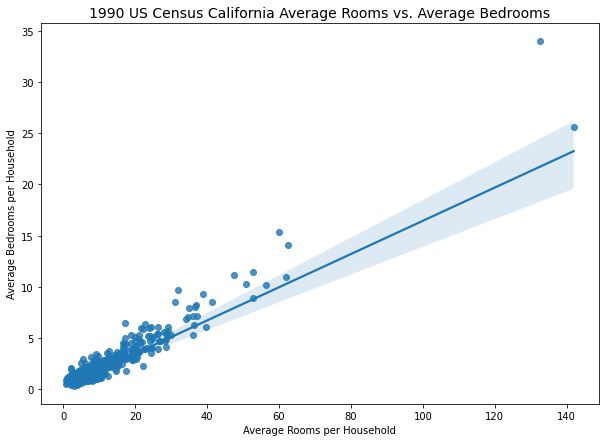

In [8]:
# regression plot
fig = plt.figure(figsize=(10,7))
ax = sns.regplot(data=df, x='AveRooms', y='AveBedrms')
ax.set_title('1990 US Census California Average Rooms vs. Average Bedrooms', fontsize=14)
ax.set_xlabel('Average Rooms per Household')
ax.set_ylabel('Average Bedrooms per Household')
plt.show()

In [9]:
# pearson's correlation coefficient
corr, _ = pearsonr(df['AveRooms'], df['AveBedrms'])
print('Average Rooms vs. Average Bedrooms Pearson\'s Correlation: %.3f' % corr)

Average Rooms vs. Average Bedrooms Pearson's Correlation: 0.848


#### Median Income & Average Rooms

While the Pandas Profiling EDA report indicated a possible high correlation between Median Income and Average Rooms, upon further inspection, the relationship between these two variables does not appear concerning. We will include both in our regression analysis.

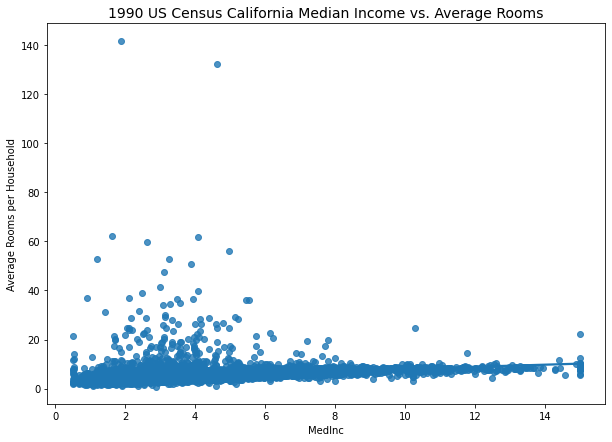

In [10]:
# regression plot
fig = plt.figure(figsize=(10,7))
ax = sns.regplot(data=df, x='MedInc', y='AveRooms')
ax.set_title('1990 US Census California Median Income vs. Average Rooms', fontsize=14)
ax.set_ylabel('Median Income (10K USD)')
ax.set_ylabel('Average Rooms per Household')
plt.show()

In [11]:
# pearson's correlation coefficient
corr, _ = pearsonr(df['MedInc'], df['AveRooms'])
print('Median Income vs. Average Rooms Pearson\'s Correlation: %.3f' % corr)

Median Income vs. Average Rooms Pearson's Correlation: 0.327


#### Latitude & Longitutde

Location is generally accepted as an extremely important factor in home values. Plotting a map of Median House Values by Latitude & Longitutde, it is apparent that the highest priced homes are concentrated along the coast near California's largest cities.

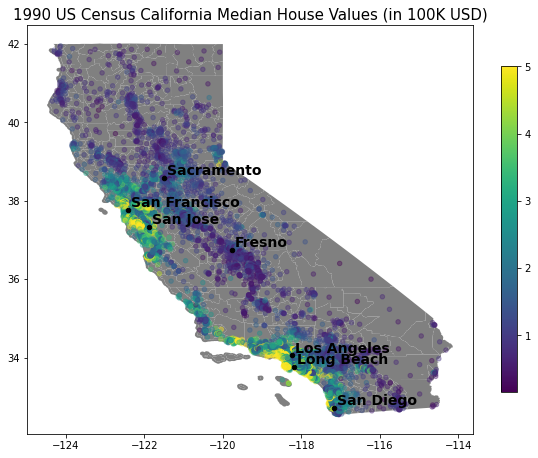

In [12]:
# plot median house value by location
crs = {'init': 'epsg:4326'}
geometry = [ Point(xy) for xy in zip(df['Longitude'], df['Latitude']) ]
geo_df = gpd.GeoDataFrame(df, geometry=geometry)
ca_map = gpd.read_file('tl_2021_06_bg/tl_2021_06_bg.shp')

cities_df = pd.read_csv('california_cities.csv')
cities_geometry = [ Point(xy) for xy in zip(cities_df['Longitude'], cities_df['Latitude']) ]
geo_cities_df = gpd.GeoDataFrame(cities_df, geometry=cities_geometry)

fig, ax = plt.subplots(figsize=(10,10))
ca_map.plot(ax=ax, color='grey')
geo_df.plot(ax=ax, marker='o', markersize=20, alpha=0.4, column=geo_df['MedHouseVal'], legend=True, legend_kwds={'shrink': 0.6})
geo_cities_df.plot(ax=ax, marker='o', markersize=20, color='black')
for x, y, label in zip(geo_cities_df.geometry.x, geo_cities_df.geometry.y, geo_cities_df['Name']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords='offset points', weight='bold',color='black', size=14)
plt.title('1990 US Census California Median House Values (in 100K USD)', fontsize=15)
plt.show()

Clearly, we want to include location into our models, but the Pandas Profiling EDA report indicated that Latitude and Longitude are highly correlated and may produce an interaction. We plot Latitude vs. Longitude and calculate the Pearson's Correlation Coefficient, confirming that we must somehow translate the idea of location into a single variable.

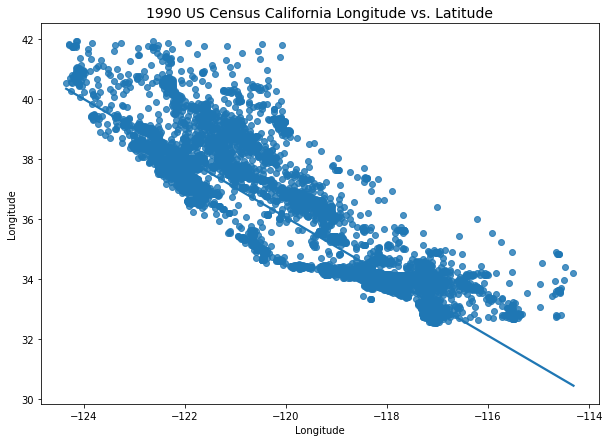

In [13]:
# regression plot
fig = plt.figure(figsize=(10,7))
ax = sns.regplot(data=df, x='Longitude', y='Latitude')
ax.set_title('1990 US Census California Longitude vs. Latitude', fontsize=14)
ax.set_ylabel('Latitude')
ax.set_ylabel('Longitude')
plt.show()

In [14]:
# pearson's correlation coefficient
corr, _ = pearsonr(df['Longitude'], df['Latitude'])
print('Longitude vs. Latitude Pearson\'s Correlation: %.3f' % corr)


Longitude vs. Latitude Pearson's Correlation: -0.925


In our research, we found there are several common methods used to translate longitude and latitude into a single variable representing geographic region. For example, looking up the associated address to find the city or zip code, or geohashing, a convenient way of expressing a location (anywhere in the world) using a short alphanumeric string. Unfortunately, these two methods produce a categorical variable with a large number of distinct values, and therefore, a large number of one-hot encoded columns. (In California, there are 1,741 zip codes.)

Another alternative found was to try clustering to make a reduced number of regions. K-Means is an extremely popular clustering method; however, it has been shown DBScan with the Haversine formula can be more effective for geospatial clustering. We will try both.

In [15]:
# dbscan
X = np.array(df[['Latitude', 'Longitude']])
db = DBSCAN(eps=2/6371., min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(X))   # min_samples = 1 to prevent noise
y = db.fit_predict(X)
geo_df['DBScan'] = y
print('Number of DBScan Clusters:',max(y)+1)

Number of DBScan Clusters: 12545


DBScan computed 12,545 clusters, far more than if we had simply used zip code! This will not work for our regression analysis. Through further exploring, we find we can approximate our DBScan results using K-Means.

In [16]:
# k-means
k = 50
kmeans_orig = KMeans(n_clusters = k)
kmeans_orig.fit(X)
y_kmeans = kmeans_orig.predict(X)
geo_df['KMeans'] = y_kmeans
print('Number of K-Means Clusters:',k)

Number of K-Means Clusters: 50


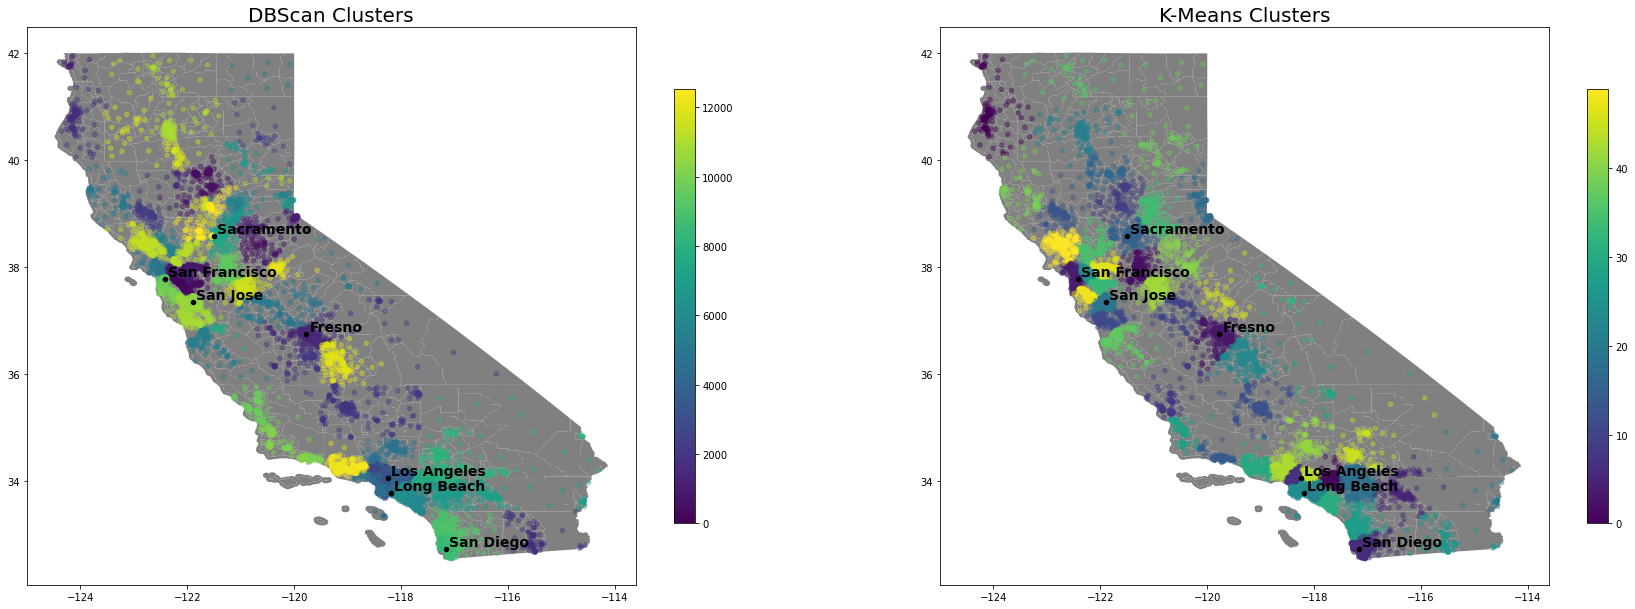

In [17]:
# plot clustering
fig, axs = plt.subplots(1,2,figsize=(30,20))
ca_map.plot(ax=axs[0], color='grey')
geo_df.plot(ax=axs[0], marker='o', markersize=20, alpha=0.4, column=geo_df['DBScan'], legend=True, legend_kwds={'shrink': 0.4})
geo_cities_df.plot(ax=axs[0], marker='o', markersize=20, color='black')
for x, y, label in zip(geo_cities_df.geometry.x, geo_cities_df.geometry.y, geo_cities_df['Name']):
    axs[0].annotate(label, xy=(x, y), xytext=(3, 3), textcoords='offset points', weight='bold',color='black', size=14)
axs[0].set_title('DBScan Clusters', fontsize=20)

ca_map.plot(ax=axs[1], color='grey')
geo_df.plot(ax=axs[1], marker='o', markersize=20, alpha=0.4, column=geo_df['KMeans'], legend=True, legend_kwds={'shrink': 0.4})
geo_cities_df.plot(ax=axs[1], marker='o', markersize=20, color='black')
for x, y, label in zip(geo_cities_df.geometry.x, geo_cities_df.geometry.y, geo_cities_df['Name']):
    axs[1].annotate(label, xy=(x, y), xytext=(3, 3), textcoords='offset points', weight='bold',color='black', size=14)
axs[1].set_title('K-Means Clusters', fontsize=20)
plt.show()

### Final Input Data

We finalize our input variables, removing Average Bedrooms and one-hot encoding our K-Means clusters that approximate geographic regions.

In [18]:
final_df = geo_df[['MedInc', 'HouseAge', 'AveRooms', 'Population', 'AveOccup', 'KMeans']]
final_df = pd.get_dummies(final_df, columns=['KMeans'], drop_first=True)
final_df['MedHouseVal'] = df['MedHouseVal']
final_df

MedInc  HouseAge  AveRooms  Population  AveOccup  KMeans_1  KMeans_2  \
0      8.3252      41.0  6.984127       322.0  2.555556         0         0   
1      8.3014      21.0  6.238137      2401.0  2.109842         0         0   
2      7.2574      52.0  8.288136       496.0  2.802260         0         0   
3      5.6431      52.0  5.817352       558.0  2.547945         0         0   
4      3.8462      52.0  6.281853       565.0  2.181467         0         0   
...       ...       ...       ...         ...       ...       ...       ...   
20635  1.5603      25.0  5.045455       845.0  2.560606         0         0   
20636  2.5568      18.0  6.114035       356.0  3.122807         0         0   
20637  1.7000      17.0  5.205543      1007.0  2.325635         0         0   
20638  1.8672      18.0  5.329513       741.0  2.123209         0         0   
20639  2.3886      16.0  5.254717      1387.0  2.616981         0         0   

       KMeans_3  KMeans_4  KMeans_5  ...  KMeans_41  KMeans_42  KMeans_43  \
0             0         0         0  ...          0          0          0   
1             0         0         0  ...          0          0          0   
2             0         0         0  ...          0          0          0   
3             0         0         0  ...          0          0          0   
4             0         0         0  ...          0          0          0   
...         ...       ...       ...  ...        ...        ...        ...   
20635         0         0         0  ...          0          0          0   
20636         0         0         0  ...          0          0          0   
20637         0         0         0  ...          0          0          0   
20638         0         0         0  ...          0          0          0   
20639         0         0         0  ...          0          0          0   

       KMeans_44  KMeans_45  KMeans_46  KMeans_47  KMeans_48  KMeans_49  \
0              0          0          0          0          0          0   
1              0          0          0          0          0          0   
2              0          0          0          0          0          0   
3              0          0          0          0          0          0   
4              0          0          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
20635          0          0          0          0          0          0   
20636          0          0          0          0          0          0   
20637          0          0          0          0          0          0   
20638          0          0          0          0          0          0   
20639          0          0          0          0          0          0   

       MedHouseVal  
0            4.526  
1            3.585  
2            3.521  
3            3.413  
4            3.422  
...            ...  
20635        0.781  
20636        0.771  
20637        0.923  
20638        0.847  
20639        0.894  

[20640 rows x 55 columns]

### Target Variable

Taking a look at our target variable, Median House Value, there does not appear to be a need to remove any extreme outliers prior to building out our regression models. We will review outliers again using regression diagnostic plots.

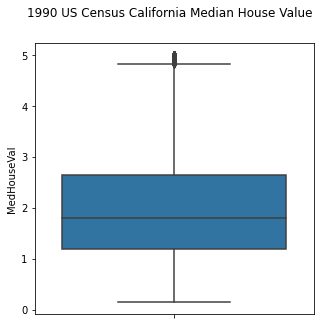

In [19]:
# boxplot of median house income
fig = plt.figure(figsize=(5,5))
sns.boxplot(y='MedHouseVal', data=final_df)
fig.suptitle('1990 US Census California Median House Value')
plt.show()

## Regression

### Scikit-learn Regression Models

In this section, we will explore and evaluate several regression methods available via sklearn, including Oridnary Least Squares (OLS), Ridge, Lasso, Partial Least Squares (PLS), and Principal Component Regression (PCR).

We start with creating data inputs and determining all required parameters.

In [20]:
# data prep
final_X = np.array(final_df.iloc[:,:-1])
final_y = final_df['MedHouseVal']
n_comp = 0

# compute covariance matrix and visualize cumulative sum of explained variances to choose right number of PCA dimensions
cov_mat = np.cov(StandardScaler().fit_transform(final_X).T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

# calculate cumulative sum of explained variances
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# determine n_component parameter
for i in range(len(cum_var_exp)):
    if cum_var_exp[i] > 0.9:
        n_comp = i + 1
        print('N-Components:', n_comp)
        break

N-Components: 46


Next, we create all our regression models.

In [21]:
# ordinary least squares
model_ols = LinearRegression()
model_ols.fit(final_X, final_y)
ols_y = model_ols.predict(final_X)

# cross-validation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# ridge
model_ridge = RidgeCV(alphas=[0.001,0.01,1,10], cv=cv)
model_ridge.fit(final_X, final_y)
ridge_y = model_ridge.predict(final_X)

# lasso
model_lasso = LassoCV(alphas=[0.001,0.01,1,10], cv=cv)
model_lasso.fit(final_X, final_y)
lasso_y = model_lasso.predict(final_X)

# principal component
model_pcr = make_pipeline(StandardScaler(), PCA(n_components=n_comp), LinearRegression())
model_pcr.fit(final_X, final_y)
pcr_y = model_pcr.predict(final_X)

# partial least squares
model_pls = PLSRegression(n_components=n_comp)
model_pls.fit(final_X, final_y)
pls_y = model_pls.predict(final_X)

As our first step in model evaluation, we compute R-Squared, Mean Absolute Error, Mean Squared Error, and Root Squared Error for all five of our regression models and display the results. 

* R-squared is a goodness-of-fit measure for linear regression models that ranges from 0 to 1 that indicates the proportion of variance in the dependent variable that the independent variables explain. 

* Mean Absolute Error (MAE) is the absolute value of the difference between the predicted values and the actual values.

* Mean Squared Error (MSE) is the average squared difference between the predicated values and the actual values.

* Root Mean Squared Error (RMSE) is the square root of the MSE, which is the most intuitive of the error measures as it has the same units as our actual values. 

For R-Squared, we want to see values closer one, and for all three error measures, smaller is better.

In [22]:
def regression_results(model_metrics, regression_type, y_true, y_pred):
    r2 = round(metrics.r2_score(y_true, y_pred),4)
    mae = round(metrics.mean_absolute_error(y_true, y_pred),4)
    mse = round(metrics.mean_squared_error(y_true, y_pred),4)
    rmse = round(np.sqrt(mse),4)
    model_metrics.append([ regression_type, r2, mae, mse, rmse ])

model_metrics = []
regression_results(model_metrics, 'OLS', final_y, ols_y)
regression_results(model_metrics, 'Ridge', final_y, ridge_y)
regression_results(model_metrics, 'Lasso', final_y, lasso_y)
regression_results(model_metrics, 'PLS', final_y, pls_y)
regression_results(model_metrics, 'PCR', final_y, pcr_y)

In [23]:
metrics_df = pd.DataFrame(model_metrics, columns = ['Regression Method','R-Squared','Mean Absolute Error','Mean Squared Error',
                                             'Root Mean Squared Error'])
metrics_df

Regression Method  R-Squared  Mean Absolute Error  Mean Squared Error  \
0               OLS     0.6850               0.4595              0.4195   
1             Ridge     0.6850               0.4595              0.4195   
2             Lasso     0.6806               0.4639              0.4253   
3               PLS     0.6849               0.4595              0.4196   
4               PCR     0.6478               0.5007              0.4690   

   Root Mean Squared Error  
0                   0.6477  
1                   0.6477  
2                   0.6522  
3                   0.6478  
4                   0.6848

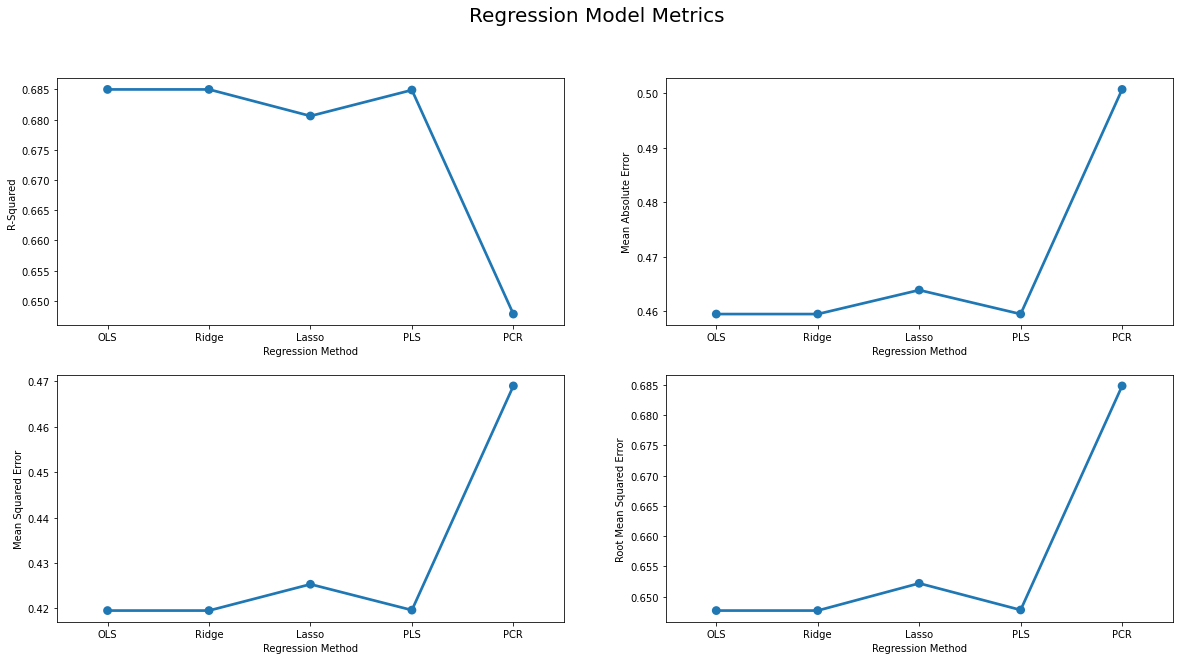

In [24]:
# plot model metrics
fig, axs = plt.subplots(2,2, figsize=(20,10))
sns.pointplot(x='Regression Method', y='R-Squared', data=metrics_df, ax=axs[0,0])
sns.pointplot(x='Regression Method', y='Mean Absolute Error', data=metrics_df, ax=axs[0,1])
sns.pointplot(x='Regression Method', y='Mean Squared Error', data=metrics_df, ax=axs[1,0])
sns.pointplot(x='Regression Method', y='Root Mean Squared Error', data=metrics_df, ax=axs[1,1])
fig.suptitle('Regression Model Metrics', size=20)
plt.show()

We find that OLS and Ridge perform the best. Interestingly, Ridge does not improve OLS.

### Statsmodel

Statsmodel is a statistical package that appears to have much more advanced regression diagnostic capabilities, similar to R. We will give it a try for OLS given that OLS performed well for sklearn.

First, let's see if our suspicions about interaction terms were correct and all the previous work on location regions was worth it.

In [25]:
# let's try this again with interaction terms
formula_ols2 = 'MedHouseVal ~ MedInc + HouseAge + AveRooms*AveBedrms + Population + AveOccup + Latitude*Longitude'
smodel_ols2 = smf.ols(formula_ols2, data=df)
results_ols2 = smodel_ols2.fit()
print(results_ols2.summary())

                            OLS Regression Results                            
Dep. Variable:            MedHouseVal   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     3192.
Date:                Sun, 20 Feb 2022   Prob (F-statistic):               0.00
Time:                        14:34:16   Log-Likelihood:                -22593.
No. Observations:               20640   AIC:                         4.521e+04
Df Residuals:                   20629   BIC:                         4.529e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -45.8279      7

Latitude and Longitude's interaction has a p-value of 0.288, far exceeding the threshold of significance (p-value > 0.05). Thus, it appears that it was appropriate for us to turn Latitude and Longitude into a single variable representing regions. Surprisingly, Average Rooms and Average Bedroom's interaction term does not have a significant p-value, so it was not necessary for us to remove it from our previous models. We generate our final OLS model using the categorical geographic regions we developed using K-Means.

In [26]:
# ols using k-means regions
formula_ols = 'MedHouseVal ~ MedInc + HouseAge + AveRooms + AveBedrms + Population + AveOccup + C(KMeans)'
model = smf.ols(formula_ols, data=df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            MedHouseVal   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     814.2
Date:                Sun, 20 Feb 2022   Prob (F-statistic):               0.00
Time:                        14:34:16   Log-Likelihood:                -20317.
No. Observations:               20640   AIC:                         4.075e+04
Df Residuals:                   20584   BIC:                         4.119e+04
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.1094      0.058     

We validate that statsmodel and sklearn OLS models have the same R-Squared values. Looking at the p-values associated with each of the coefficients, it appears that specific geographic regions and the average number of rooms are significant.

Next, we will recreate the diagnositic plots available in R. Please note that the following code was modified from this article: https://medium.com/towards-data-science/going-from-r-to-python-linear-regression-diagnostic-plots-144d1c4aa5a.

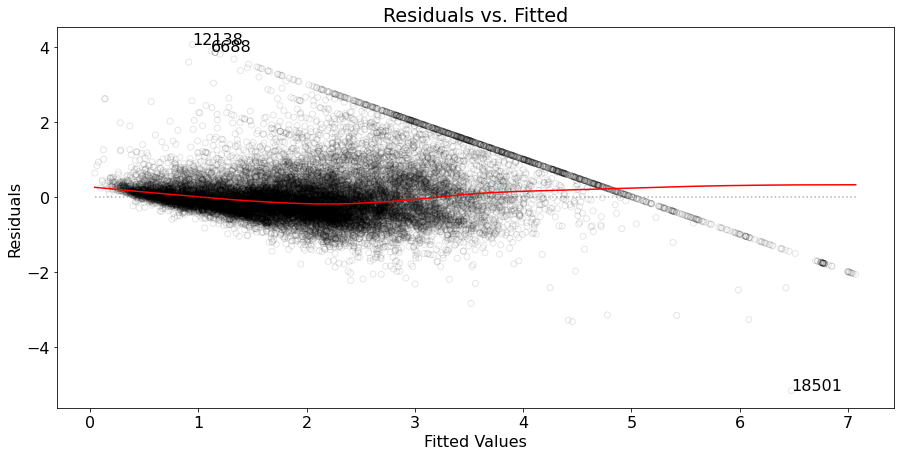

In [27]:
# residuals vs. fitted
residuals = results.resid
fitted = results.fittedvalues
smoothed = lowess(residuals,fitted)
top3 = abs(residuals).sort_values(ascending = False)[:3]

plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (15,7)
fig, ax = plt.subplots()
ax.scatter(fitted, residuals, edgecolors = 'k', facecolors = 'none', alpha = 0.1)
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('Residuals')
ax.set_xlabel('Fitted Values')
ax.set_title('Residuals vs. Fitted')
ax.plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)

for i in top3.index:
    ax.annotate(i,xy=(fitted[i],residuals[i]))

plt.show()

In the Residuals vs. Fitted plot, we perfer to see a straight, horizontal lowess smoothing curve (in red) and residual points that are equally distanced from the lowess curve across the entire plot. Our model's lowess smoothing curve is pretty decently horizontal. However, we do see a fanning effect on the residuals (tigher distance to the lowess curve on the left with increasing distance to the curve as we move right across the plot), which indicates possible heteroscedasticity. This can mean our standard error calculations are unreliable.

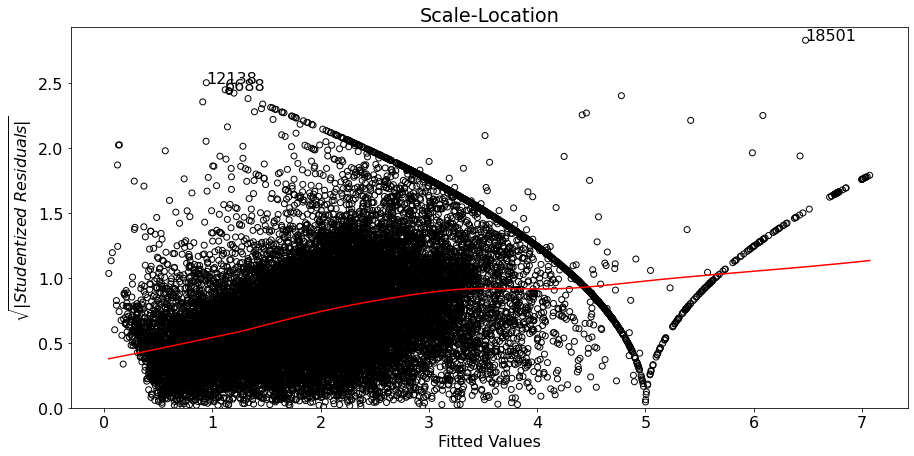

In [28]:
# scale - location
student_residuals = results.get_influence().resid_studentized_internal
sqrt_student_residuals = pd.Series(np.sqrt(np.abs(student_residuals)))
sqrt_student_residuals.index = results.resid.index
smoothed = lowess(sqrt_student_residuals,fitted)
top3 = abs(sqrt_student_residuals).sort_values(ascending = False)[:3]

fig, ax = plt.subplots()
ax.scatter(fitted, sqrt_student_residuals, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('$\sqrt{|Studentized \ Residuals|}$')
ax.set_xlabel('Fitted Values')
ax.set_title('Scale-Location')
ax.set_ylim(0,max(sqrt_student_residuals)+0.1)
for i in top3.index:
    ax.annotate(i,xy=(fitted[i],sqrt_student_residuals[i]))
plt.show()

In the Scale-Location plot, we see our lowess smoothing curve trending up, which again indicates heteroscedasticity and that our standard error calculations are unreliable.

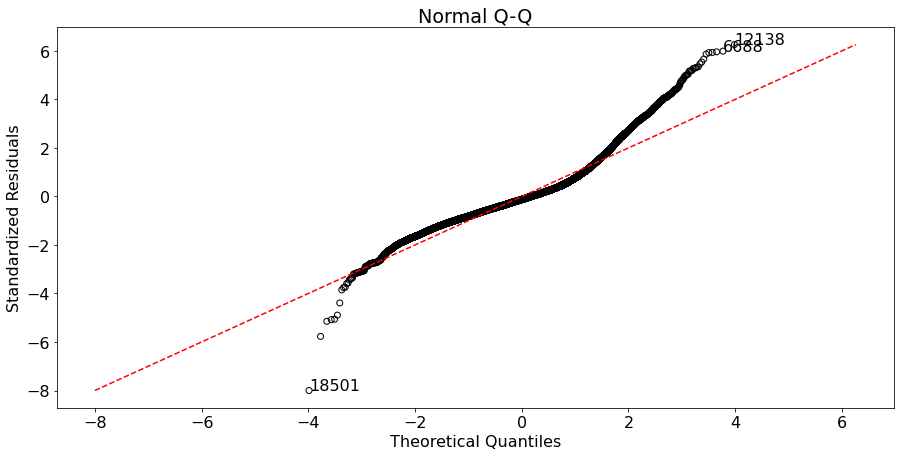

In [29]:
# qqplot of standardized residuals
sorted_student_residuals = pd.Series(results.get_influence().resid_studentized_internal)
sorted_student_residuals.index = results.resid.index
sorted_student_residuals = sorted_student_residuals.sort_values(ascending = True)
df_stats = pd.DataFrame(sorted_student_residuals)
df_stats.columns = ['sorted_student_residuals']
df_stats['theoretical_quantiles'] = stats.probplot(df_stats['sorted_student_residuals'], dist = 'norm', fit = False)[0]
rankings = abs(df_stats['sorted_student_residuals']).sort_values(ascending = False)
top3 = rankings[:3]

fig, ax = plt.subplots()
x = df_stats['theoretical_quantiles']
y = df_stats['sorted_student_residuals']
ax.scatter(x,y, edgecolor = 'k',facecolor = 'none')
ax.set_title('Normal Q-Q')
ax.set_ylabel('Standardized Residuals')
ax.set_xlabel('Theoretical Quantiles')
ax.plot([np.min([x,y]),np.max([x,y])],[np.min([x,y]),np.max([x,y])], color = 'r', ls = '--')
for val in top3.index:
    ax.annotate(val,xy=(df_stats['theoretical_quantiles'].loc[val],df_stats['sorted_student_residuals'].loc[val]))
plt.show()

Another important diagnostic plot is the QQPlot of Standardized Residuals, where we determine if our model's standardized residuals are normally distributed. Here we see that the standardized residuals get too far away from the red line at either end of the plot, indicating they are not normal. Additionally, it seems that a few observations are of particular concern.

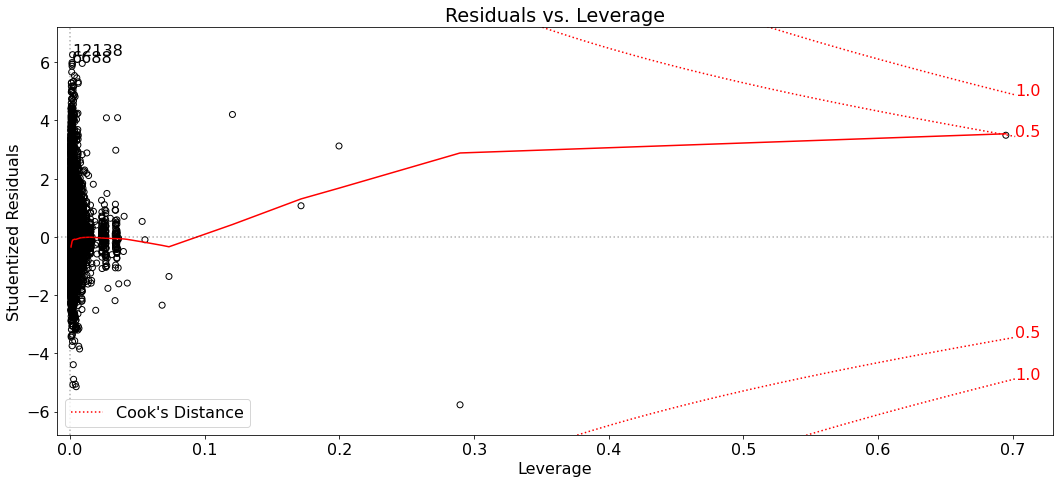

In [30]:
# residuals vs. leverage
student_residuals = pd.Series(results.get_influence().resid_studentized_internal)
student_residuals.index = results.resid.index
df_stats = pd.DataFrame(student_residuals)
df_stats.columns = ['student_residuals']
df_stats['leverage'] = results.get_influence().hat_matrix_diag
smoothed = lowess(df_stats['student_residuals'],df_stats['leverage'])
sorted_student_residuals = abs(df_stats['student_residuals']).sort_values(ascending = False)
top3 = sorted_student_residuals[:3]

fig, ax = plt.subplots()
x = df_stats['leverage']
y = df_stats['student_residuals']
xpos = max(x)+max(x)*0.01  
ax.scatter(x, y, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('Studentized Residuals')
ax.set_xlabel('Leverage')
ax.set_title('Residuals vs. Leverage')
ax.set_ylim(min(y)-min(y)*0.15,max(y)+max(y)*0.15)
ax.set_xlim(-0.01,max(x)+max(x)*0.05)
plt.tight_layout()
for val in top3.index:
    ax.annotate(val,xy=(x.loc[val],y.loc[val]))

cooksx = np.linspace(min(x), xpos, 50)
p = len(results.params)
poscooks1y = np.sqrt((p*(1-cooksx))/cooksx)
poscooks05y = np.sqrt(0.5*(p*(1-cooksx))/cooksx)
negcooks1y = -np.sqrt((p*(1-cooksx))/cooksx)
negcooks05y = -np.sqrt(0.5*(p*(1-cooksx))/cooksx)

ax.plot(cooksx,poscooks1y,label = "Cook's Distance", ls = ':', color = 'r')
ax.plot(cooksx,poscooks05y, ls = ':', color = 'r')
ax.plot(cooksx,negcooks1y, ls = ':', color = 'r')
ax.plot(cooksx,negcooks05y, ls = ':', color = 'r')
ax.plot([0,0],ax.get_ylim(), ls=":", alpha = .3, color = 'k')
ax.plot(ax.get_xlim(), [0,0], ls=":", alpha = .3, color = 'k')
ax.annotate('1.0', xy = (xpos, poscooks1y[-1]), color = 'r')
ax.annotate('0.5', xy = (xpos, poscooks05y[-1]), color = 'r')
ax.annotate('1.0', xy = (xpos, negcooks1y[-1]), color = 'r')
ax.annotate('0.5', xy = (xpos, negcooks05y[-1]), color = 'r')
ax.legend()
plt.show()

The Residuals vs. Leverage plot with Cook's Distance allows us to understand if particular observations have an unusally large effect on our model. Here we can see there is a single point with a Cook's distance around 0.5 that we should remove in future iterations of our model.

## Conclusion

The 1990 US Census California Housing data provides a rich data set for experimenting with regression methods and libraries. Through exploratory data analysis, we found that both Average Rooms & Average Bedrooms and Latitude & Longitude were highly correlated. We were able to translate Latitude and Longitude into a single categorical variable representing geographic regions using K-Means.

When comparing R-Squared, Mean Absolute Error, Mean Squared Error, and Root Mean Squared Error, Ordinarly Least Squares performed as well as Ridge and Partial Least Squares and better than Lasso and Principal Component Regression. In terms of implementation, we found statsmodel to be a great improvement over sklearn. Statsmodel provides much a more thorough and intuitive summary, as well as allows us to easily generate regression diagnostic plots.

Our final OLS model had a relatively high R-Squared of 0.685, but the diagnostic plots indicate there is still work to be done on our model. In terms of predicting Median House Value, it appears that there is good reason for the ubiquitous real estate mantra, "Location, location, location!" Our approximated categorical variable for geographic region had significant coefficients, along with the average number of rooms.